In [3]:
!pip install pandas_datareader

In [4]:
import math
import numpy as np
import os
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import pandas_datareader as pdr
from datetime import datetime, timedelta

In [5]:
#Get the stock
ticker = 'SBUX'
stock ="Starbucks Corporation"
#  here we will use n  days historical data to predict next day closing
ts_points = 120
# train_data[0:60,0]  

today = datetime.today()
# start_date ='2016-01-01'
start_date = (today - timedelta(days=5*365) ).strftime('%Y-%m-%d')

# end_date   = today.strftime('%Y-%m-%d')
end_date = (today - timedelta(days=62) ).strftime('%Y-%m-%d')

stock_df = pdr.DataReader(ticker, data_source="yahoo", start=start_date, end=end_date)

In [6]:
# Date is an index but to be sure , let's sort
stock_df = stock_df.sort_index(ascending=True)
stock_df

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2017-04-18,58.480000,57.590000,57.590000,58.349998,5449300.0,52.940701
2017-04-19,59.490002,58.500000,58.599998,59.040001,12000600.0,53.566738
2017-04-20,60.340000,59.560001,59.709999,60.080002,12445900.0,54.510334
2017-04-21,60.689999,60.150002,60.200001,60.610001,8800000.0,54.991192
2017-04-24,61.380001,60.889999,61.000000,61.110001,10721300.0,55.444847
...,...,...,...,...,...,...
2022-02-09,97.970001,96.199997,96.250000,97.129997,9353700.0,96.639999
2022-02-10,96.809998,94.980003,95.459999,95.309998,9098800.0,95.309998
2022-02-11,96.489998,93.360001,95.589996,93.730003,6924800.0,93.730003


In [7]:
# check for nulls
stock_df.isna().sum()

High         0
Low          0
Open         0
Close        0
Volume       0
Adj Close    0
dtype: int64

In [8]:
# Get shape
stock_df.shape

(1218, 6)

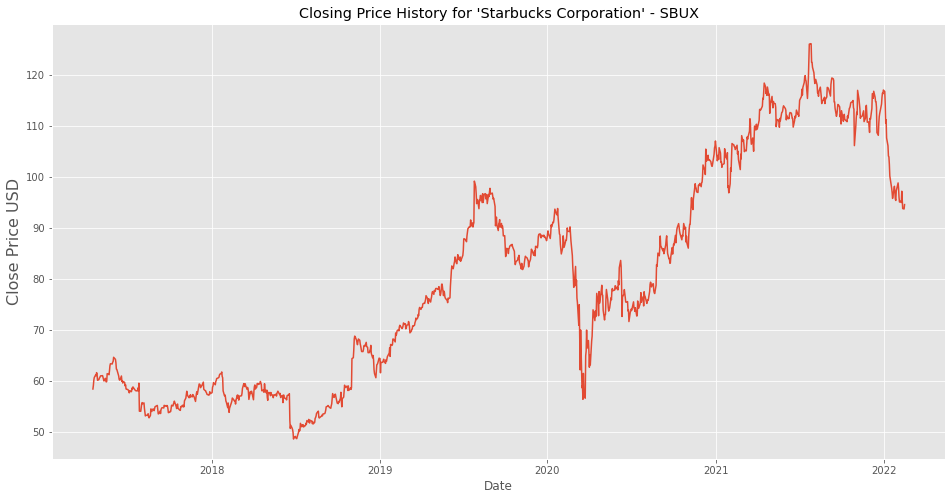

In [13]:
# Visualize closing price history
plt.figure(figsize=(16,8))
plt.title (f"Closing Price History for '{stock}' - {ticker}")
plt.plot(stock_df['Close'])
plt.xlabel('Date')
plt.ylabel('Close Price USD', fontsize=16)
plt.savefig('Images/his_'+ticker+'.png')
plt.show()

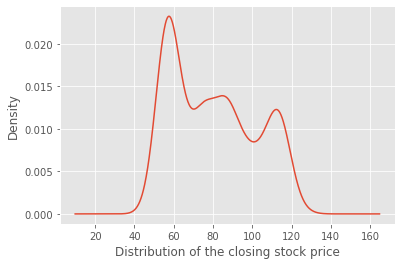

In [15]:
stock_df['Close'].plot.density()
plt.xlabel('Distribution of the closing stock price')
plt.savefig('Images/den_'+ticker+'.png')
plt.show()

In [16]:
# DF with only close
TSdata_df = stock_df.filter(['Close'])
TSdata_df


,Close
Date,
2017-04-18,58.349998
2017-04-19,59.040001
2017-04-20,60.080002
2017-04-21,60.610001
2017-04-24,61.110001
...,...
2022-02-09,97.129997
2022-02-10,95.309998
2022-02-11,93.730003


In [17]:
TSdata_arr = TSdata_df.values # this creates an array of Close Price
TSdata_arr

array([[58.34999847],
       [59.04000092],
       [60.08000183],
       ...,
       [93.73000336],
       [93.65000153],
       [94.51000214]])

In [18]:
from statsmodels.tsa.stattools import adfuller
import pandas as pd
import numpy as np

# ADF Test
result = adfuller(TSdata_arr, autolag='AIC')

print('ADF Statistic: %f' % result[0])

print('p-value: %f' % result[1])

print('Critical Values:')

for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))
if result[0] < result[4]["5%"]:
    print ("Reject Ho - Time Series is Stationary")
else:
    print ("Failed to Reject Ho - Time Series is Non-Stationary")

ADF Statistic: -1.159905
p-value: 0.690601
Critical Values:
	1%: -3.436
	5%: -2.864
	10%: -2.568
Failed to Reject Ho - Time Series is Non-Stationary


In [19]:
df2 = TSdata_df['Close'].diff().dropna().to_frame()
df2

,Close
Date,
2017-04-19,0.690002
2017-04-20,1.040001
2017-04-21,0.529999
2017-04-24,0.500000
2017-04-25,-0.150002
...,...
2022-02-09,2.209999
2022-02-10,-1.820000
2022-02-11,-1.579994


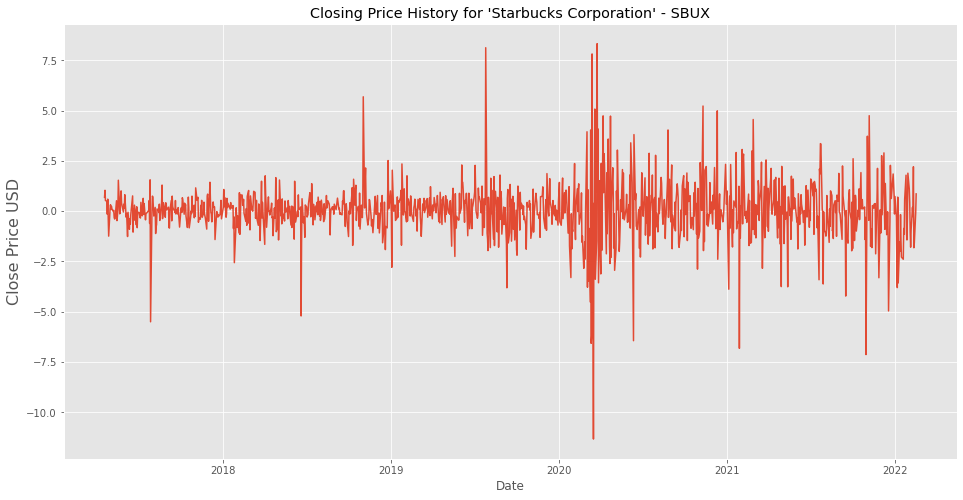

In [22]:
# Visualize closing price history
plt.figure(figsize=(16,8))
plt.title (f"Closing Price History for '{stock}' - {ticker}")
plt.plot(df2['Close'])
plt.xlabel('Date')
plt.ylabel('Close Price USD', fontsize=16)
plt.savefig('Images/diff_'+ticker+'.png')
plt.show()

In [23]:
# TSdata_arr = df2.filter(['Close']).values
# TSdata_arr

In [24]:
# Scale the Data
scaler = MinMaxScaler(feature_range =(0,1))
scaled_data = scaler.fit_transform(TSdata_arr)
# scaled_data

In [25]:
training_data_len = math.ceil(len(TSdata_arr) * 0.75)
training_data_len

914

In [26]:
# Created scaled training dataset
train_data = scaled_data[0:training_data_len]
train_data.shape

(914, 1)

In [27]:
# Split
X_train = []
y_train = []

for i in range(ts_points, len(train_data)):
    X_train.append(train_data[i-ts_points:i,0])
    y_train.append(train_data[i,0])
    # if i <= ts_points+3:
    #     print(X_train)
    #     print(y_train)
    #     print()


In [28]:
# convert X_train and y_train to numpy arrays for LSTM
X_train, y_train = np.array(X_train), np.array(y_train)

In [29]:
print (X_train.shape)
print (y_train.shape)

(794, 120)
(794,)


In [30]:
# LSTM network expects a 3D input (No_of_Samples, number of time steps, and number of features) no_of_features = 1 (Close)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_train.shape

(794, 120, 1)

In [31]:
training_data_len - ts_points

794

In [32]:
# hidden_nodes = int(2/3 * (X_train.shape[1] * 1))
# print(f"The number of hidden nodes is {hidden_nodes}.")

In [33]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.LSTM(50, return_sequences=True, input_shape=(X_train.shape[1],1)))
model.add(tf.keras.layers.LSTM(50, return_sequences=False))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(25))
model.add(tf.keras.layers.Dense(1))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 120, 50)           10400     
                                                                 
 lstm_1 (LSTM)               (None, 50)                20200     
                                                                 
 dropout (Dropout)           (None, 50)                0         
                                                                 
 dense (Dense)               (None, 25)                1275      
                                                                 
 dense_1 (Dense)             (None, 1)                 26        
                                                                 
Total params: 31,901
Trainable params: 31,901
Non-trainable params: 0
_________________________________________________________________


In [34]:
model.compile(optimizer='adam', loss='mean_squared_error')

In [35]:
import os
from tensorflow.keras.callbacks import ModelCheckpoint

batch_size=64

os.makedirs("chk_points/", exist_ok=True)
chkpoint_path="chk_points/weights.{epoch}.hdf5"

# Create chk points
chkpt_callback = ModelCheckpoint(filepath=chkpoint_path,
                              verbose=1,
                              save_weights_only=True,
                              save_freq="epoch",
                              period=5)

# chkpoint_path = "chk_points/cp-{epoch:04d}.ckpt"
# chkpt_callback = tf.keras.callbacks.ModelCheckpoint(
#     filepath=chkpoint_path, 
#     verbose=1, 
#     save_weights_only=True,
#     save_freq=5*batch_size)                    

# model.save_weights(chkpoint_path.format(epoch=0))    


In [36]:
# training_data_len
# scaled_data

In [37]:
# model.fit(X_train, y_train, batch_size=batch_size, epochs=50, validation_split=0.43, callbacks=[chkpt_callback])
model.fit(X_train, y_train, batch_size=64 ,epochs=100)

Epoch 1/100
13/13 [==============================] - 5s 144ms/step - loss: 0.0228
Epoch 2/100
13/13 [==============================] - 2s 143ms/step - loss: 0.0068
Epoch 3/100
13/13 [==============================] - 2s 143ms/step - loss: 0.0037
Epoch 4/100
13/13 [==============================] - 2s 157ms/step - loss: 0.0031
Epoch 5/100
13/13 [==============================] - 2s 135ms/step - loss: 0.0026
Epoch 6/100
13/13 [==============================] - 2s 143ms/step - loss: 0.0022
Epoch 7/100
13/13 [==============================] - 2s 138ms/step - loss: 0.0021
Epoch 8/100
13/13 [==============================] - 2s 142ms/step - loss: 0.0020
Epoch 9/100
13/13 [==============================] - 2s 142ms/step - loss: 0.0020
Epoch 10/100
13/13 [==============================] - 2s 138ms/step - loss: 0.0018
Epoch 11/100
13/13 [==============================] - 2s 130ms/step - loss: 0.0019
Epoch 12/100
13/13 [==============================] - 2s 132ms/step - loss: 0.0017
Epoch 13/100


13/13 [==============================] - 2s 137ms/step - loss: 7.5849e-04
Epoch 98/100
13/13 [==============================] - 2s 140ms/step - loss: 6.6133e-04
Epoch 99/100
13/13 [==============================] - 2s 146ms/step - loss: 7.6421e-04
Epoch 100/100
13/13 [==============================] - 2s 141ms/step - loss: 7.0279e-04


In [38]:
model.save('../assets/Model_'+ticker+'.h5')

In [39]:
# test_data = scaled_data[training_data_len:]

# Bring in the last 'ts_points' (120 values) from training set so when X_test is used to predict , predictions have same shape as Y_test
# The for loop starts with 'ts_points' that means the resultant array will have 120 less rows
test_data = scaled_data[training_data_len-ts_points:]



In [40]:
X_test = []
y_test = TSdata_arr[training_data_len:]
for i in range(ts_points, len(test_data)):
    X_test.append(test_data[i-ts_points:i,0])


In [41]:
# convert the data to a numpy array to use it in LSTM MODEL
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],  X_test.shape[1], 1))

In [42]:
from sklearn.metrics import mean_squared_error

In [43]:
# Models predicted price for X_train
predictions_tr = model.predict(X_train)
predictions_tr = scaler.inverse_transform(predictions_tr)

y_train_tr =  scaler.inverse_transform(y_train.reshape(-1,1))
rmse_tr = math.sqrt(mean_squared_error(y_train_tr, predictions_tr))
rmse_tr

1.740390089533204

In [44]:
# Models predicted price for X_test
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)

In [45]:
y_test.shape, predictions.shape

((304, 1), (304, 1))

In [46]:
# RMSE to check accuracy

rmse = math.sqrt(mean_squared_error(y_test, predictions))
rmse

2.4092120582275447

In [47]:
# Plot
train = TSdata_df[:training_data_len]
actual = TSdata_df[training_data_len:]
actual['Predictions'] = predictions
actual

C:\Users\software\AppData\Local\Temp/ipykernel_7512/2747295380.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actual['Predictions'] = predictions


,Close,Predictions
Date,,
2020-12-02,98.910004,97.979988
2020-12-03,100.110001,98.213150
2020-12-04,102.279999,98.744171
2020-12-07,101.410004,99.890961
2020-12-08,101.209999,100.742615
...,...,...
2022-02-09,97.129997,94.827675
2022-02-10,95.309998,94.975388
2022-02-11,93.730003,94.945274


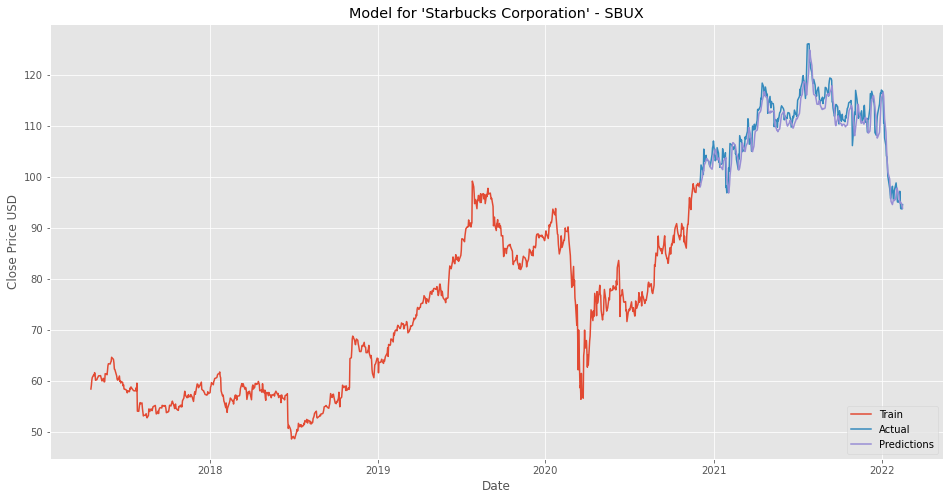

In [49]:
plt.figure(figsize=(16,8))
plt.title(f"Model for '{stock}' - {ticker}")
plt.xlabel("Date")
plt.ylabel("Close Price USD")
plt.plot(train['Close'])
plt.plot(actual[['Close', 'Predictions']])
plt.legend(['Train', 'Actual', 'Predictions'], loc='lower right')
plt.savefig('Images/'+ticker+'.png')
plt.show()

# TEST

In [50]:
# for predictions add 100 extra days to make sure it has more than ts_points to make up for missing days (weekends and holidays)

fetch_days = ts_points + 100    

sd =  today - timedelta(days=fetch_days)
sd = sd.strftime('%Y-%m-%d')

ed = today.strftime('%Y-%m-%d')
ed

next_day = (today + timedelta(days=1) ).strftime('%Y-%m-%d')
# next_day

In [51]:
# get the quote
quote = pdr.DataReader(ticker, data_source="yahoo", start=sd, end=ed)
new_df = quote.filter(['Close'])
last_n_days = ts_points
last_n_days_arr = new_df[-last_n_days:].values 

In [52]:
last_n_days_scaled = scaler.transform(last_n_days_arr)
X_test = []
X_test.append(last_n_days_scaled)
X_test = np.array(X_test)
X_test = np.reshape(X_test,(X_test.shape[0], X_test.shape[1],1))


In [53]:
##########################loading saved model ###############################
new_model = tf.keras.models.load_model('../assets/Model_'+ticker+'.h5')

# Check its architecture
new_model.summary()
nmpred_price = new_model.predict(X_test)
nmpred_price = scaler.inverse_transform(nmpred_price)
nmpred_price = nmpred_price[0][0]
print(f"Predicted Closing price for '{stock}' on {next_day} is {nmpred_price:.4f}")

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 120, 50)           10400     
                                                                 
 lstm_1 (LSTM)               (None, 50)                20200     
                                                                 
 dropout (Dropout)           (None, 50)                0         
                                                                 
 dense (Dense)               (None, 25)                1275      
                                                                 
 dense_1 (Dense)             (None, 1)                 26        
                                                                 
Total params: 31,901
Trainable params: 31,901
Non-trainable params: 0
_________________________________________________________________
Predicted Closing price for 'Starbucks Corporation' 

In [54]:
pred_price = model.predict(X_test)
pred_price = scaler.inverse_transform(pred_price)
pred_price = pred_price[0][0]
print(f"Predicted Closing price for '{stock}' on {next_day} is {pred_price:.4f}")

Predicted Closing price for 'Starbucks Corporation' on 2022-04-19 is 79.0629


In [55]:
# verify
d1 = today - timedelta(days=5)
d1 = d1.strftime('%Y-%m-%d')

quote2 = pdr.DataReader(ticker, data_source="yahoo", start=d1)
quote2

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2022-04-12,81.269997,79.650002,80.830002,79.790001,8472500,79.790001
2022-04-13,81.309998,79.610001,79.879997,80.919998,8604400,80.919998
2022-04-14,81.080002,79.250000,80.750000,79.500000,9555700,79.500000
